In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from utils import load_series_dfs
from pathlib import Path

In [4]:
series_dfs = load_series_dfs(data_dir=r"C:\Users\johan\Documents\FH_Master\data", filename="final_learning_dfs.pkl")
series_dfs['FL_00024702.PLAN.MengeHH'].columns

Index(['consumption', 'hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf',
       'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', 'w_tb10',
       'w_tb20', 'CEGH_WAP', 'THE_WAP'],
      dtype='object')

In [14]:
import json, numpy as np, pandas as pd
from tslearn.metrics import cdist_dtw
from tslearn.preprocessing import TimeSeriesResampler

ARTIFACT_DIR = Path("../data_public/cluster_mediods/artifacts_medoid_classifier")

# laden
blob = np.load(ARTIFACT_DIR / "medoid_classifier.npz", allow_pickle=True)
MEDOID_TS   = blob["medoid_series"]        # (k, target_len)
MEDOID_KEYS = blob["medoid_keys"].tolist() # list[str]
PARAMS      = json.loads((ARTIFACT_DIR / "params.json").read_text())
RADIUS      = PARAMS["sakoe_chiba_radius"]

def zscore(x):
    m, s = np.nanmean(x), np.nanstd(x)
    s = s if s and np.isfinite(s) else 1.0
    return (x - m) / s


def preprocess_series_1d(s: pd.Series, params=PARAMS) -> np.ndarray:
    """Gibt 1D-Array der Länge target_len zurück (float32)."""
    s = s.astype(float).copy()
    # gleiche Schritte wie im Training
    s3 = s.resample(params["resample_rule"]).mean().interpolate(limit=params["interpolate_limit"])
    if params["zscore"]:
        s3 = pd.Series(zscore(s3.values), index=s3.index)

    # -> (len,1) für tslearn
    arr = s3.values.astype("float32").reshape(-1, 1)

    # auf einheitliche Länge bringen (wie bei dir: Padding -> Resample)
    # (a) auf max-Länge padden macht man im Batch; hier tricksen wir, indem wir ans Ende den letzten Wert wiederholen
    if arr.shape[0] < params["target_len"]:
        pad = np.full((params["target_len"], 1), arr[-1, 0], dtype="float32")
        pad[:arr.shape[0], 0] = arr[:, 0]
        arr = pad
    # (b) resample exakt auf target_len
    arr = TimeSeriesResampler(sz=params["target_len"]).fit_transform(arr[None, ...])[0]
    return arr[:, 0]  # zurück zu 1D


def assign_series_to_medoid(new_df: pd.DataFrame) -> dict:
    """
    Erwartet new_df mit Spalte 'consumption' und DatetimeIndex.
    Gibt dict mit Zuordnung, Distanz und Ranking zurück.
    """
    x = preprocess_series_1d(new_df['consumption'], PARAMS)        # (target_len,)
    X = x.reshape(1, -1, order="C")                                # (1, target_len)
    M = MEDOID_TS                                                  # (k, target_len)

    # tslearn.cdist_dtw erwartet shape (n_ts, len), kein extra Feature-Dim
    dists = cdist_dtw(X, M, global_constraint="sakoe_chiba", sakoe_chiba_radius=RADIUS)[0]  # (k,)
    order = np.argsort(dists)
    best  = int(order[0])
    return {
        "assigned_medoid_key": MEDOID_KEYS[best],
        "distance": float(dists[best]),
        "ranked_candidates": [(MEDOID_KEYS[i], float(dists[i])) for i in order.tolist()]
    }


In [9]:
series_dfs['FL_00024702.PLAN.MengeHH']['consumption']

von  | von
2015-01-01 06:00:00    48.447
2015-01-01 07:00:00    45.788
2015-01-01 08:00:00    43.109
2015-01-01 09:00:00    41.749
2015-01-01 10:00:00    39.900
                        ...  
2018-12-31 19:00:00    32.223
2018-12-31 20:00:00    29.348
2018-12-31 21:00:00    24.727
2018-12-31 22:00:00    17.483
2018-12-31 23:00:00    15.874
Name: consumption, Length: 35178, dtype: float64

In [11]:
new_df = series_dfs['FL_00024702.PLAN.MengeHH']  # DataFrame mit 'consumption' und DatetimeIndex
result = assign_series_to_medoid(new_df)
print(result)

{'assigned_medoid_key': 'CV_00003432.PLAN.Menge', 'distance': 9.682886176480524, 'ranked_candidates': [('CV_00003432.PLAN.Menge', 9.682886176480524), ('FL_00024360.PLAN.MengeGA', 45.414202091947175), ('KN_00000067.PLAN.Menge', 68.3078805368751)]}


<Axes: xlabel='von  | von'>

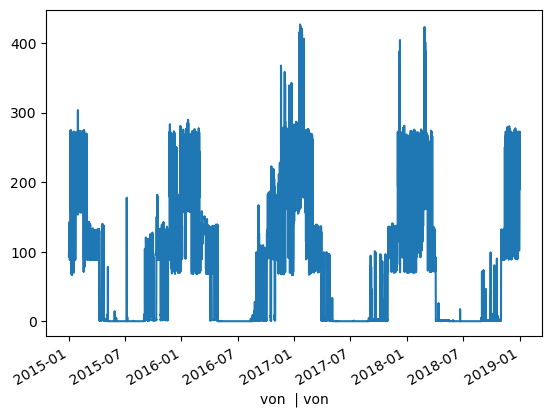

In [13]:
series_dfs['KN_00001886.PLAN.MengeKW']['consumption'].plot()

In [16]:
MEDOID_KEYS

['CV_00003432.PLAN.Menge',
 'KN_00000067.PLAN.Menge',
 'FL_00024360.PLAN.MengeGA']

In [17]:
feature_sets = {
    "rmse_toleranz": ['hour', 'w_tl', 'w_ff', 'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP'],  # Sweetspot k=7, drop weekday
    "bester_score":  ['w_tl','w_tb10'],  # drop THE_WAP
    "minimaler_rmse":['hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf',
                      'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr',
                      'w_tb10', 'w_tb20', 'CEGH_WAP', 'THE_WAP']  # alle, kein Drop
}

In [18]:
import time
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_sarimax(df, features, order=(1,0,2), seasonal_order=(1,0,1,24)):
    """
    Trainiert SARIMAX auf df['consumption'] mit exogenen Features
    und gibt RMSE, MAE, Trainingszeit und Vorhersagezeit zurück.
    """
    # sauberes Index-Handling
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df[~df.index.duplicated(keep='first')].sort_index()
    df = df.asfreq("h").interpolate()  # gleiche Frequenz + Gaps füllen

    # Train/Test Split (z. B. letztes Jahr als Test)
    split_date = df.index.max() - pd.DateOffset(years=1)
    train = df.loc[:split_date]
    test  = df.loc[split_date + pd.Timedelta(hours=1):]

    y_true = test['consumption']

    # --- Training ---
    start = time.time()
    mod = SARIMAX(
        train['consumption'],
        exog=train[features],
        order=order, seasonal_order=seasonal_order,
        enforce_stationarity=True, enforce_invertibility=True
    )
    res = mod.fit(disp=False, method="powell", maxiter=300)
    train_time = time.time() - start

    # --- Prediction ---
    start = time.time()
    y_pred = res.predict(start=test.index[0], end=test.index[-1], exog=test[features])
    pred_time = time.time() - start

    # --- Metrics ---
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "Train_time_s": train_time,
        "Predict_time_s": pred_time,
        "n_train": len(train),
        "n_test": len(test)
    }

In [19]:
results = []

for med_key in MEDOID_KEYS:  # deine drei Medoid-Keys
    df = series_dfs[med_key]  # DataFrame mit 'consumption' und Features
    for fs_name, features in feature_sets.items():
        metrics = evaluate_sarimax(df, features)
        metrics.update({"medoid": med_key, "feature_set": fs_name})
        results.append(metrics)

df_results = pd.DataFrame(results)
print(df_results)

           RMSE           MAE  Train_time_s  Predict_time_s  n_train  n_test  \
0  2.423750e+02  2.253766e+02    204.984675        0.210430    26298    8760   
1  1.502195e+02  1.226870e+02    103.185202        0.171229    26298    8760   
2  1.126163e+02  8.349764e+01    420.426144        0.211480    26298    8760   
3  3.805249e-01  1.082295e-02    117.225185        0.196371    26298    8760   
4  3.805249e-01  1.082295e-02     94.689381        0.197313    26298    8760   
5  3.805249e-01  1.082295e-02    149.766894        0.200958    26298    8760   
6  2.139510e+07  1.691078e+06     95.039564        0.241060    26298    8760   
7  2.139515e+07  1.691251e+06    104.910545        0.225939    26298    8760   
8  2.139510e+07  1.691080e+06    222.741256        0.210819    26298    8760   

                     medoid     feature_set  
0    CV_00003432.PLAN.Menge   rmse_toleranz  
1    CV_00003432.PLAN.Menge    bester_score  
2    CV_00003432.PLAN.Menge  minimaler_rmse  
3    KN_0000006

In [20]:
df_results

,RMSE,MAE,Train_time_s,Predict_time_s,n_train,n_test,medoid,feature_set
0,2.423750e+02,2.253766e+02,204.984675,0.210430,26298,8760,CV_00003432.PLAN.Menge,rmse_toleranz
1,1.502195e+02,1.226870e+02,103.185202,0.171229,26298,8760,CV_00003432.PLAN.Menge,bester_score
2,1.126163e+02,8.349764e+01,420.426144,0.211480,26298,8760,CV_00003432.PLAN.Menge,minimaler_rmse
3,3.805249e-01,1.082295e-02,117.225185,0.196371,26298,8760,KN_00000067.PLAN.Menge,rmse_toleranz
4,3.805249e-01,1.082295e-02,94.689381,0.197313,26298,8760,KN_00000067.PLAN.Menge,bester_score
5,3.805249e-01,1.082295e-02,149.766894,0.200958,26298,8760,KN_00000067.PLAN.Menge,minimaler_rmse
6,2.139510e+07,1.691078e+06,95.039564,0.241060,26298,8760,FL_00024360.PLAN.MengeGA,rmse_toleranz
7,2.139515e+07,1.691251e+06,104.910545,0.225939,26298,8760,FL_00024360.PLAN.MengeGA,bester_score
8,2.139510e+07,1.691080e+06,222.741256,0.210819,26298,8760,FL_00024360.PLAN.MengeGA,minimaler_rmse


In [21]:
2.139510e+07

21395100.0

In [23]:
8.349764e+01

83.49764

In [24]:
1.226870e+02

122.687

<Axes: xlabel='von  | von'>

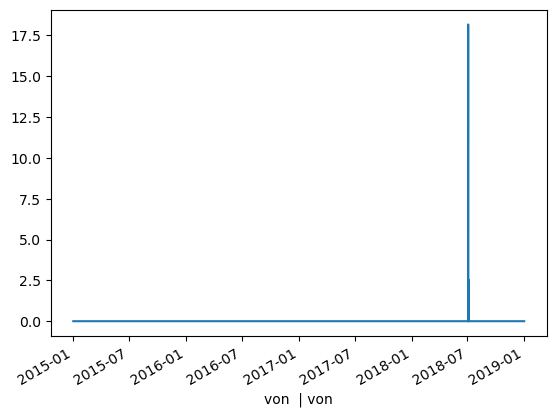

In [27]:
series_dfs['KN_00000067.PLAN.Menge']['consumption'].plot()